## Emotion Regression
- Evaluation: Averaged Pearson correlations of all emotions
- Model: BiLSTM with Self-attention
- Word Embeddings: Random Init **vs** pretrained?
- Training: direct training **vs** pretrained on Twitter sentiment

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import time
import os
import sys

from tensorflow.contrib.rnn import LSTMStateTuple
from scipy.stats import pearsonr
from nltk.tokenize import TweetTokenizer

In [3]:
# Bi-LSTM emotion regressor
def create_cell(num_units, cell_type, forget_bias=1.0):
    """
    cell: build a recurrent cell
        num_units: number of hidden cell units
        cell_type: LSTM, GRU, LN_LSTM
    """
    if cell_type == "LSTM":
        cell = tf.nn.rnn_cell.BasicLSTMCell(num_units, forget_bias=forget_bias)

    elif cell_type == "GRU":
        cell = tf.nn.rnn_cell.GRUCell(num_units)

    elif cell_type == "LN_LSTM":
        cell = tf.contrib.rnn.LayerNormBasicLSTMCell(
            num_units,
            forget_bias=forget_bias,
            layer_norm=True)

    else:
        raise ValueError("Unknown cell type %s" % cell_type)

    return cell


def build_rnn_cell(num_layers, num_units, cell_type, forget_bias=1.0):
    """
    rnn_cell: build a multi-layer rnn cell
        num_layers: number of hidden layers
    """
    cell_seq = []
    for i in range(num_layers):
        cell = create_cell(num_units, cell_type, forget_bias)
        cell_seq.append(cell)

    if num_layers > 1:
        rnn_cell = tf.nn.rnn_cell.MultiRNNCell(cell_seq)
    else:
        rnn_cell = cell_seq[0]

    return rnn_cell


def self_attention_scores(hs, num_attn_hidden):
    """
    Pass hidden outputs to a feedforward net for self attention scores
    Use 2-layer DNN with tanh as in https://arxiv.org/pdf/1804.06658.pdf
        hs: [batch_size, max_time, num_hiddens]
    Returns:
        attn_scores: [batch_size, max_time, 1]
    """
    attn_a1 = tf.nn.tanh(tf.layers.dense(hs, num_attn_hidden))
    attn_a2 = tf.nn.tanh(tf.layers.dense(attn_a1, num_attn_hidden))
    e = tf.layers.dense(attn_a2, 1)
    attn_scores = tf.nn.softmax(tf.squeeze(e, axis=-1))
    attn_scores = tf.expand_dims(attn_scores, -1)

    return attn_scores


def build_emotion_regressor(
        embeddings, source_ids, num_layers, num_units, num_emotions,
        cell_type, forget_bias=1.0, bidir=False, self_attention=False,
        num_attn_hidden=128, dtype=tf.float32, name="encoder"):
    """
    Emotion Regressor for sentence following https://arxiv.org/abs/1804.06658
    Christos Baziotis et al., arXiv (2018), NTUA-SLP at SemEval-2018
        Task 1: Predicting Affective Content in Tweets
        with Deep Attentive RNNs and Transfer Learning

    encoder: build rnn encoder for Seq2seq
        source_ids: [batch_size, max_time]
        bidir: bidirectional or unidirectional

    Returns:
        encoder_outputs: [batch_size, max_time, num_units]
        encoder_states: (StateTuple(shape=(batch_size, num_units)), ...)
    """
    with tf.variable_scope(name):
        # embedding lookup, embed_inputs: [max_time, batch_size, num_units]
        embed_inputs = tf.nn.embedding_lookup(embeddings, source_ids)
        output_layer = tf.layers.Dense(num_emotions, name="output_layer")

        # bidirectional
        if bidir:
            encoder_states = []
            layer_inputs = embed_inputs

            for i in range(num_layers):
                with tf.variable_scope("layer_%d" % (i + 1)):
                    fw_cell = build_rnn_cell(
                        1, num_units, cell_type, forget_bias)
                    bw_cell = build_rnn_cell(
                        1, num_units, cell_type, forget_bias)

                    outs = tf.nn.bidirectional_dynamic_rnn(
                        fw_cell, bw_cell, layer_inputs,
                        dtype=dtype,
                        swap_memory=True)
                    bi_outputs, (state_fw, state_bw) = outs

                    if cell_type == "LSTM":
                        state_c = state_fw.c + state_bw.c
                        state_h = state_fw.h + state_bw.h
                        encoder_states.append(LSTMStateTuple(state_c, state_h))
                    else:
                        encoder_states.append(state_fw + state_bw)

                    if i < num_layers - 1:
                        layer_inputs = tf.layers.dense(
                            tf.concat(bi_outputs, -1), num_units)

            if self_attention:
                encoder_hs = tf.concat(bi_outputs, -1)
                attn_scores = self_attention_scores(
                    encoder_hs, num_attn_hidden)
                output_h = tf.reduce_sum(attn_scores * encoder_hs, axis=1)

            else:
                fw_h = bi_outputs[0][:, -1, :]
                bw_h = bi_outputs[1][:, 0, :]
                output_h = tf.concat([fw_h, bw_h], -1)

        # unidirectional
        else:
            rnn_cell = build_rnn_cell(
                num_layers, num_units, cell_type, forget_bias)
            encoder_outputs, encoder_states = tf.nn.dynamic_rnn(
                rnn_cell, embed_inputs,
                dtype=dtype,
                swap_memory=True)

            if self_attention:
                attn_scores = self_attention_scores(
                    encoder_outputs, num_attn_hidden)
                output_h = tf.reduce_sum(attn_scores * encoder_hs, axis=-1)
            else:
                output_h = encoder_outputs[:, -1, :]

        outputs = tf.nn.sigmoid(output_layer(output_h))

    return outputs

In [4]:
def init_embeddings(vocab_size, embed_size, dtype=tf.float32,
                    initializer=None, initial_values=None,
                    name='embeddings'):
    """
    embeddings:
        initialize trainable embeddings or load pretrained from files
    """
    with tf.variable_scope(name):
        if initial_values:
            embeddings = tf.Variable(initial_value=initial_values,
                                     name="embeddings", dtype=dtype)
        else:
            if initializer is None:
                initializer = tf.contrib.layers.xavier_initializer()
            embeddings = tf.Variable(
                initializer(shape=(vocab_size, embed_size)),
                name="embeddings", dtype=dtype)

        # id_0 represents all-zero token, id_1 represents UNK token
        zero_embed = tf.zeros(shape=[1, embed_size])
        unk_embed = tf.get_variable("UNK", [1, embed_size], dtype)
        embeddings = tf.concat([zero_embed, unk_embed, embeddings], axis=0)

    return embeddings

In [5]:
embeddings = init_embeddings(1000, 128)

In [6]:
source_ids = tf.placeholder(tf.int32, [None, None])
outputs = build_emotion_regressor(embeddings, source_ids, num_layers=2, num_units=256,
                                  num_emotions=4, cell_type="LSTM", bidir=True,
                                  self_attention=True, num_attn_hidden=128, name="e3")

In [7]:
# Compute loss
def compute_loss(source_ids, targets, embeddings, num_layers, num_units,
                 num_emotions, cell_type, enc_bidir, self_attention=False,
                 num_attn_hidden=128, l2_regularize=None, name="emo_reg"):
    """
    Creates a emotion regressor and returns squared loss.
    """
    with tf.name_scope(name):
        # build emotion regressor
        outputs = build_emotion_regressor(
            embeddings, source_ids, num_layers, num_units,
            num_emotions, cell_type, bidir=enc_bidir,
            self_attention=self_attention, num_attn_hidden=num_attn_hidden,
            name=name)

        # compute loss
        with tf.name_scope('loss'):
            reduced_loss = tf.losses.mean_squared_error(
                labels=targets, predictions=outputs)

            if l2_regularize is None:
                return reduced_loss, outputs
            else:
                l2_loss = tf.add_n([tf.nn.l2_loss(v)
                                    for v in tf.trainable_variables()
                                    if not('bias' in v.name)])

                total_loss = reduced_loss + l2_regularize * l2_loss
                return total_loss, outputs

In [8]:
targets = tf.placeholder(tf.float32, [None, 4])
loss = tf.losses.mean_squared_error(labels=targets, predictions=outputs)

In [9]:
# saving and load
def load(saver, sess, logdir):
    print("Trying to restore saved checkpoints from {} ...".format(logdir),
          end="")

    ckpt = tf.train.get_checkpoint_state(logdir)
    if ckpt:
        print("  Checkpoint found: {}".format(ckpt.model_checkpoint_path))
        global_step = int(ckpt.model_checkpoint_path
                          .split('/')[-1]
                          .split('-')[-1])
        print("  Global step was: {}".format(global_step))
        print("  Restoring...", end="")
        saver.restore(sess, ckpt.model_checkpoint_path)
        print(" Done.")
        return global_step
    else:
        print(" No checkpoint found.")
        return None


def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir), end="")
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')

In [10]:
# Inference and Evaluation
def eval_mean_pearson(source_ids, predictions, sess, data, labels):
    """
    Compute Pearson's correlation coeff w.r.t. each emotion
    and average all coeffs as the evaluation metric.
    Ref: SemEval-2018 Task 1: Affect in Tweets (AIT-2018)
    """
    pred = sess.run(predictions, feed_dict={source_ids: data})
    pearsons = [pearsonr(pred[:, i], labels[:, i])[0] for i in range(4)]
    mean_pearson = np.mean(pearsons)
    return mean_pearson

### Data Preprocessing

In [11]:
# tokenize
def loadfilename(filename):
    emotions = ["anger", "fear", "joy", "sadness"]
    data = {}

    for ith, emo in enumerate(emotions):
        df = pd.read_csv(filename.format(emo), "\t").values
        for ID, tweet, _, score in df:
            if ID not in data:
                # emotion is a 4-dimensional real-valued vector
                data[ID] = {
                    "text": tweet,
                    "emotion": np.zeros(4)
                }

            data[ID]["emotion"][ith] = float(score)

    return data


def tokenize(data):
    """
    NLTK Tweet: Tokenizations for training data, build a dictionary
        data: {ID: {text: tweet, emotion: vector}}
    """
    twtknzr = TweetTokenizer(reduce_len=True, strip_handles=True)
    words = {}
    index = 0
    tk_r = []
    strings = []

    # Build dictionary
    for ID in data.keys():
        tk_r.append(twtknzr.tokenize(data[ID]["text"]))
        tk_ids = []

        for word in tk_r[-1]:
            # strip hashtag's #
            if word[0] == "#":
                word = word[1:]

            if word not in words:
                words[word] = index
                index += 1

            strings.append(word)
            tk_ids.append(words[word])

        # transform text into token_id sequence
        data[ID]["ids"] = tk_ids

    return words


def tokenize_test(data, words):
    """
    NLTK Tweet: Tokenizations for dev/valid/test data
        data: {ID: {text: tweet, emotion: vector}}
        words: predefined dictionary
    """
    twtknzr = TweetTokenizer(reduce_len=True, strip_handles=True)
    num_unk = 0
    total_word = 0
    tk_r = []

    for ID in data.keys():
        tk_r.append(twtknzr.tokenize(data[ID]["text"]))
        tk_ids = []
        for word in tk_r[-1]:
            if word[0] == "#":
                word = word[1:]

            if word not in words:
                num_unk += 1
            else:
                tk_ids.append(words[word])

            total_word += 1

        data[ID]["ids"] = tk_ids

    return num_unk, total_word

In [12]:
# preprocess
def to_output_form(data):
    """
    Transform data into a list of strings output format
    """
    processed = []
    for ID in data.keys():
        text = " ".join(np.array(data[ID]["ids"], dtype=str).tolist())
        emo = " ".join(data[ID]["emotion"].astype(str).tolist())
        processed.append(text + "," + emo)

    return processed


def preprocess():
    train_filename = "./EI-reg-En-train/EI-reg-En-{}-train.txt"
    train_data = loadfilename(train_filename)
    train_words = tokenize(train_data)
    train_processed = to_output_form(train_data)

    train_df = pd.DataFrame(data={"0": train_processed})
    train_df.to_csv("emodata_train", header=None, index=None)

    word_df = pd.DataFrame(data={"0": train_words})
    word_df.to_csv("emodata_word_ids", header=None, sep="\t")
    print("Training set processed. With {} words and {} sentences.".format(
          len(train_words), len(train_data)))

    dev_filename = "./2018-EI-reg-En-dev/2018-EI-reg-En-{}-dev.txt"
    dev_data = loadfilename(dev_filename)
    num_unk, total_word = tokenize_test(dev_data, train_words)
    dev_processed = to_output_form(dev_data)

    dev_df = pd.DataFrame(data={"0": dev_processed})
    dev_df.to_csv("emodata_dev", header=None, index=None)
    print("Dev set processed: {} UNKs, {} words and {} sentences.".format(
          num_unk, total_word, len(dev_data)))

    return train_data, train_words, dev_data

In [13]:
train_data, train_words, dev_data = preprocess()

Training set processed. With 15448 words and 6908 sentences.
Dev set processed: 1810 UNKs, 15694 words and 893 sentences.


0.9470179502026635


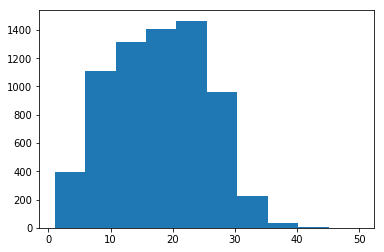

In [14]:
# parsed sentence length distribution
ls = np.array([len(train_data[ID]["ids"]) for ID in train_data.keys()])

plt.hist(ls)
print((ls < 30).sum() / float(len(ls)))

In [15]:
# glove = pd.read_csv("glove.twitter.27B.100d.txt", " ", error_bad_lines=True, header=None, index_col=0)

### Training: BiLSTM + SelfAttn, RanInit, Direct

In [16]:
def loadfile(filename, max_length):
    df = pd.read_csv(filename, header=None)
    data = []
    labels = []
    for row in df[0].values:
        row = row.split(",")
        if len(row) == 2:
            ids, emos = row
            ids = np.array(ids.split(" "), dtype=np.int32)
            emos = np.array(emos.split(" "), dtype=np.float)
        else:
            ids = np.array(row[0].split(" "), dtype=np.float)
            emos = None

        if len(ids) < max_length:
            # represents constant zero padding
            pads = -np.ones(max_length - len(ids), dtype=np.int32)
            ids = np.concatenate((ids, pads))
        else:
            ids = ids[:max_length]

        data.append(ids)
        labels.append(emos)

    return np.array(data), np.array(labels)


def get_config(config):
    num_layers = config["model"]["num_layers"]
    num_units = config["model"]["num_units"]
    num_emotions = config["model"]["num_emotions"]
    cell_type = config["model"]["cell_type"]
    enc_bidir = config["model"]["bidirectional"]
    self_attention = config["model"]["self_attention"]
    num_attn_hidden = config["model"]["num_attn_hidden"]

    # infer_batch_size = config["inference"]["infer_batch_size"]
    # infer_type = config["inference"]["type"]
    # beam_size = config["inference"]["beam_size"]
    # max_iter = config["inference"]["max_length"]

    train_config = config["training"]
    logdir = train_config["logdir"]
    restore_from = train_config["restore_from"]
    l2_regularize = train_config["l2_regularize"]

    learning_rate = train_config["learning_rate"]
    gpu_fraction = train_config["gpu_fraction"]
    max_checkpoints = train_config["max_checkpoints"]
    train_steps = train_config["train_steps"]
    batch_size = train_config["batch_size"]
    print_every = train_config["print_every"]
    checkpoint_every = train_config["checkpoint_every"]

    loss_fig = train_config["loss_fig"]
    pearson_fig = train_config["pearson_fig"]

    return (num_layers, num_units, num_emotions, cell_type, enc_bidir,
            self_attention, num_attn_hidden, logdir, restore_from,
            l2_regularize, learning_rate, gpu_fraction, max_checkpoints,
            train_steps, batch_size, print_every, checkpoint_every,
            loss_fig, pearson_fig)

In [17]:
import yaml


config_details = {
    "Name": "BiLSTM_SelfAttn_EmoRegressor",
    "embeddings": {
        "embed_size": 128,
    },
    "model": {
        "num_layers": 2,
        "num_units": 256,
        "num_emotions": 4,
        "cell_type": "LSTM",
        "bidirectional": True,
        "self_attention": True,
        "num_attn_hidden": 128,
    },    
    "inference": {
        "infer_batch_size": 15,
        "infer_source_file": "./emodata_dev",
        "infer_source_max_length": 25,
        "output_path": "./emoprediction.txt",
    },
    "training": {
        "l2_regularize": None,
        "logdir": "./log_emoReg/",
        "restore_from": "./log_emoReg/",
        "learning_rate": 1e-3,
        "batch_size": 64,
        "gpu_fraction": 0.05,
        "max_checkpoints": 10000,
        "train_steps": 4000,
        "print_every": 20,
        "checkpoint_every": 500,
        "max_length": 25,
        "loss_fig": "./training_loss_over_time",
        "pearson_fig": "./pearson_over_time",
    }
}

with open('config_emoBiLSTM_selfattn.yaml', "w") as f:
    yaml.dump({"configuration": config_details}, f, default_flow_style=False)

In [18]:
with open('config_emoBiLSTM_selfattn.yaml') as f:
    # use safe_load instead load
    config = yaml.safe_load(f)["configuration"]

name = config["Name"]

In [19]:
# Load Data
print("Loading data ...")
max_length = config["training"]["max_length"]
train_data, train_labels = loadfile("./emodata_train", max_length)
dev_data, dev_labels = loadfile("./emodata_dev", max_length)
word_ids = pd.read_csv("emodata_word_ids", header=None, sep="\t")

# id_0 represents all-zero token
embed_shift = 1
train_data += embed_shift
dev_data += embed_shift
n_data = len(train_data)
print("\tDone.")

# Construct or load embeddings
print("Initializing embeddings ...")
vocab_size = len(word_ids)
embed_size = config["embeddings"]["embed_size"]
embeddings = init_embeddings(vocab_size, embed_size, name=name)
print("\tDone.")

(num_layers, num_units, num_emotions, cell_type, enc_bidir, self_attention,
 num_attn_hidden, logdir, restore_from, l2_regularize, learning_rate,
 gpu_fraction, max_checkpoints, train_steps, batch_size, print_every,
 checkpoint_every, loss_fig, pearson_fig) = get_config(config)

# Build the model and compute losses
source_ids = tf.placeholder(tf.int32, [None, None], name="source")
targets = tf.placeholder(tf.float32, [None, num_emotions], name="target")

print("Building model architecture ...")
loss, predictions = compute_loss(
    source_ids, targets, embeddings, num_layers, num_units,
    num_emotions, cell_type, enc_bidir, self_attention,
    num_attn_hidden, l2_regularize, name)
print("\tDone.")

Loading data ...
	Done.
Initializing embeddings ...
	Done.
Building model architecture ...
	Done.


In [20]:
# Even if we restored the model, we will treat it as new training
# if the trained model is written into an arbitrary location.
is_overwritten_training = logdir != restore_from

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   epsilon=1e-4)
trainable = tf.trainable_variables()
optim = optimizer.minimize(loss, var_list=trainable)

# Set up session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False,
                                        gpu_options=gpu_options))
init = tf.global_variables_initializer()
sess.run(init)

# Saver for storing checkpoints of the model.
saver = tf.train.Saver(var_list=tf.trainable_variables(),
                       max_to_keep=max_checkpoints)

try:
    saved_global_step = load(saver, sess, restore_from)
    if is_overwritten_training or saved_global_step is None:
        # The first training step will be saved_global_step + 1,
        # therefore we put -1 here for new or overwritten trainings.
        saved_global_step = -1

except Exception:
    print("Something went wrong while restoring checkpoint. "
          "Training is terminated to avoid the overwriting.")
    raise

Trying to restore saved checkpoints from ./log_emoReg/ ... No checkpoint found.


Start training ...
step 0 - loss = 0.19550, dev_loss = 0.15968, r = 0.0060, dev_r = 0.0015, (0.416 sec/step)
Storing checkpoint to ./log_emoReg/ ... Done.
step 20 - loss = 0.08551, dev_loss = 0.07890, r = -0.0688, dev_r = -0.0015, (0.097 sec/step)
step 40 - loss = 0.06926, dev_loss = 0.09955, r = -0.0044, dev_r = -0.0008, (0.096 sec/step)
step 60 - loss = 0.05220, dev_loss = 0.08167, r = 0.0029, dev_r = 0.0006, (0.077 sec/step)
step 80 - loss = 0.05985, dev_loss = 0.08139, r = 0.0801, dev_r = 0.0011, (0.106 sec/step)
step 100 - loss = 0.06005, dev_loss = 0.08156, r = 0.0020, dev_r = 0.0026, (0.093 sec/step)
step 120 - loss = 0.05175, dev_loss = 0.08232, r = 0.0569, dev_r = 0.0032, (0.082 sec/step)
step 140 - loss = 0.05733, dev_loss = 0.08082, r = -0.0126, dev_r = 0.0053, (0.091 sec/step)
step 160 - loss = 0.05650, dev_loss = 0.08235, r = 0.0561, dev_r = 0.0066, (0.077 sec/step)
step 180 - loss = 0.05316, dev_loss = 0.08115, r = 0.0435, dev_r = 0.0081, (0.101 sec/step)
step 200 - loss 

step 1740 - loss = 0.05249, dev_loss = 0.08101, r = 0.0746, dev_r = 0.0605, (0.088 sec/step)
step 1760 - loss = 0.05741, dev_loss = 0.08175, r = 0.0946, dev_r = 0.0621, (0.079 sec/step)
step 1780 - loss = 0.05658, dev_loss = 0.08185, r = 0.0714, dev_r = 0.0640, (0.090 sec/step)
step 1800 - loss = 0.06029, dev_loss = 0.08246, r = 0.1030, dev_r = 0.0671, (0.109 sec/step)
step 1820 - loss = 0.06069, dev_loss = 0.08053, r = 0.0649, dev_r = 0.0680, (0.086 sec/step)
step 1840 - loss = 0.05027, dev_loss = 0.08181, r = 0.1441, dev_r = 0.0723, (0.078 sec/step)
step 1860 - loss = 0.06029, dev_loss = 0.08111, r = 0.1422, dev_r = 0.0772, (0.087 sec/step)
step 1880 - loss = 0.06821, dev_loss = 0.08325, r = 0.2288, dev_r = 0.0828, (0.085 sec/step)
step 1900 - loss = 0.05466, dev_loss = 0.08067, r = 0.1574, dev_r = 0.0878, (0.095 sec/step)
step 1920 - loss = 0.05645, dev_loss = 0.08055, r = 0.2242, dev_r = 0.1068, (0.083 sec/step)
step 1940 - loss = 0.05580, dev_loss = 0.08036, r = 0.1329, dev_r = 0.

step 3480 - loss = 0.00220, dev_loss = 0.07173, r = 0.9796, dev_r = 0.4628, (0.089 sec/step)
step 3500 - loss = 0.00624, dev_loss = 0.07225, r = 0.9576, dev_r = 0.4659, (0.079 sec/step)
Storing checkpoint to ./log_emoReg/ ... Done.
step 3520 - loss = 0.00344, dev_loss = 0.07295, r = 0.9683, dev_r = 0.4580, (0.078 sec/step)
step 3540 - loss = 0.00722, dev_loss = 0.07244, r = 0.9406, dev_r = 0.4595, (0.085 sec/step)
step 3560 - loss = 0.00728, dev_loss = 0.07249, r = 0.9544, dev_r = 0.4605, (0.092 sec/step)
step 3580 - loss = 0.00593, dev_loss = 0.07227, r = 0.9522, dev_r = 0.4618, (0.086 sec/step)
step 3600 - loss = 0.00596, dev_loss = 0.07028, r = 0.9445, dev_r = 0.4804, (0.113 sec/step)
step 3620 - loss = 0.00704, dev_loss = 0.07166, r = 0.9429, dev_r = 0.4623, (0.103 sec/step)
step 3640 - loss = 0.00606, dev_loss = 0.07216, r = 0.9499, dev_r = 0.4571, (0.094 sec/step)
step 3660 - loss = 0.00560, dev_loss = 0.07048, r = 0.9559, dev_r = 0.4754, (0.078 sec/step)
step 3680 - loss = 0.005

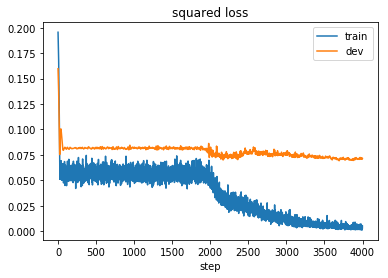

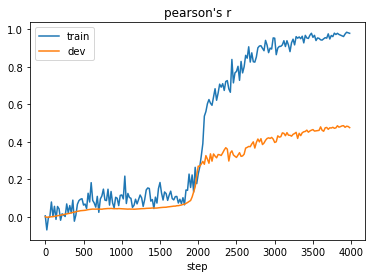

In [21]:
# ##### Training #####
last_saved_step = saved_global_step
num_steps = saved_global_step + train_steps
losses = []
dev_losses = []
steps = []
pearsons = []
dev_pearsons = []

print("Start training ...")
try:
    for step in range(saved_global_step + 1, num_steps):
        start_time = time.time()

        indexes = np.random.choice(n_data, batch_size)
        batch_source = train_data[indexes]
        batch_labels = train_labels[indexes]

        feed_dict = {
            source_ids: batch_source,
            targets: batch_labels,
        }

        loss_value, _ = sess.run([loss, optim], feed_dict=feed_dict)
        dev_loss = sess.run(
            loss, feed_dict={source_ids: dev_data, targets: dev_labels})
        losses.append(loss_value)
        dev_losses.append(dev_loss)

        duration = time.time() - start_time
        if step % print_every == 0:
            train_mean_pearson = eval_mean_pearson(
                source_ids, predictions, sess, batch_source, batch_labels)

            # evaluation on dev data
            dev_mean_pearson = eval_mean_pearson(
                source_ids, predictions, sess, dev_data, dev_labels)

            steps.append(step)
            pearsons.append(train_mean_pearson)
            dev_pearsons.append(dev_mean_pearson)

            info = 'step {:d} - loss = {:.5f}, dev_loss = {:.5f}, '
            info += 'r = {:.4f}, dev_r = {:.4f}, ({:.3f} sec/step)'
            print(info.format(step, loss_value, dev_loss,
                  train_mean_pearson, dev_mean_pearson, duration))

        if step % checkpoint_every == 0:
            save(saver, sess, logdir, step)
            last_saved_step = step

except KeyboardInterrupt:
    # Introduce a line break after ^C so save message is on its own line.
    print()

finally:
    if step > last_saved_step:
        save(saver, sess, logdir, step)

    # plot loss
    plt.figure()
    plt.plot(losses, label="train")
    plt.plot(dev_losses, label="dev")
    plt.title("squared loss")
    plt.xlabel("step")
    plt.legend()
    plt.savefig(loss_fig)

    # plot pearson's r
    plt.figure()
    plt.plot(steps, pearsons, label="train")
    plt.plot(steps, dev_pearsons, label="dev")
    plt.title("pearson's r")
    plt.xlabel("step")
    plt.legend()
    plt.savefig(pearson_fig)

#### Inference

In [22]:
# Load Data
print("Loading data ...")
infer_filename = config["inference"]["infer_source_file"]
max_length = config["inference"]["infer_source_max_length"]
infer_data, _ = loadfile(infer_filename, max_length)
word_ids = pd.read_csv("emodata_word_ids", header=None, sep="\t")

# id_0 represents all-zero token
embed_shift = 1
infer_data += embed_shift
print("\tDone.")

Loading data ...
	Done.


In [23]:
print("Start inferring ...")
emo_predicts = []
infer_batch_size = config["inference"]["infer_batch_size"]
n_data = infer_data.shape[0]
n_pad = n_data % infer_batch_size
if n_pad > 0:
    n_pad = infer_batch_size - n_pad

pad = np.zeros((n_pad, infer_data.shape[1]), dtype=np.int32)
infer_data = np.concatenate((infer_data, pad))

for ith in range(int(len(infer_data) / infer_batch_size)):
    start = ith * infer_batch_size
    end = (ith + 1) * infer_batch_size
    batch = infer_data[start:end]

    preds = sess.run(predictions, feed_dict={source_ids: batch})
    emo_predicts.append(preds)

emo_predicts = np.concatenate(emo_predicts)[:n_data]
np.savetxt(config["inference"]["output_path"], emo_predicts, fmt='%.5f')
print("\tDone.")

Start inferring ...
	Done.


### BiLSTM + SelfAttn, RanInit, Pretrained on Sentiment